# Approach

1. > compare Embeddings (```minorminer```) and choose the best
1. > compare Chain Settings and choose the best
1. > compare Anneal Times and choose the best
1. > compare Anneal Schedules and choose the best

## QUBO

### Imports

In [1]:
import sys
sys.path.append("..")
from qubo_util import *

import dimod
import numpy as np
import pandas as pd
import dwave.inspector
import matplotlib.pyplot as plt
from dwave.system.samplers import DWaveSampler
from dwave.embedding.chain_strength import scaled, uniform_torque_compensation
from dwave.system import DWaveSampler, FixedEmbeddingComposite, EmbeddingComposite

### Config

In [2]:
from dwave.cloud import Client
client = Client.from_config(config_file='/Users/jonas/Library/Application Support/dwave/dwave.conf')

### Jobs

In [3]:
### Lets define the basics

bend = [0, 1, 2]
weld = [3, 4]
paint =  [5]

bend_length = 2
weld_length = 3
paint_length = 6

t_step = 3
t_step_in_sec = 30

In [4]:
jobs = [(0, 0, 1, 1, 2, 3),
 (1, 0, 2, 3, 0, 3)]

In [5]:
# OrderNo, PartNo, BendingLines, WeldingPoints, PaintTime, DueDate 

m_t_steps = max_time(jobs, bend_length, weld_length, paint_length)

m_time = m_t_steps * t_step_in_sec
    
print('The maximal maketime for the given operations is: ' + str(m_time) + ' second(s).\nWhich is equal to: ' + str(m_t_steps) + ' time steps.\n\n')

The maximal maketime for the given operations is: 810 second(s).
Which is equal to: 27 time steps.




In [6]:
operations = ops(jobs, bend, weld, paint, bend_length, weld_length, paint_length, t_step)

print('Anzahl an Kombinationen: ' + str(len(operations)) + '\n')

Anzahl an Kombinationen: 49



### Parameters

In [7]:
alpha = 2
beta = 1.5
gamma = 2
delta = 0.035

QUBO = get_QUBO(jobs, operations, alpha, beta, gamma, delta, bend_length, weld_length, paint_length, bend, weld, paint)
qubo_dictionary = qubo_to_dictionary_ohne_null(QUBO, operations)


# Run

## Get Embedding with ```  minorminer  ``` as part of EmbeddingComposite() and safe it

https://docs.dwavesys.com/docs/latest/handbook_embedding.html#example-clique-embedding-a-sparse-bqm

https://docs.dwavesys.com/docs/latest/handbook_qpu.html?highlight=sampleset_1#read-anneal-cycles

In [8]:
bqm = dimod.BinaryQuadraticModel.from_numpy_matrix(QUBO)
qpu = DWaveSampler(solver={'topology__type': 'pegasus'})

In [9]:
# Each run with 500 shots (more runs with less shots yield better results than less runs with more shots)
numr = 500

# Chain Strength = Max(QUBO) // Analog zur D Wave Dokumentation

chnstr = find_chstr(QUBO)+1

# Empty array
data=[]

### And Visualize embedding,  check for Chain Breaks and run inspection with ```dwave.inspector.```

#### First Embedding

In [10]:
sampler = EmbeddingComposite(qpu)
sampleset1A = sampler.sample(bqm, 
                           return_embedding=True, 
                           answer_mode="raw", 
                           num_reads=numr, 
                           chain_strength= chnstr)
embedding1 = sampleset1A.info["embedding_context"]["embedding"]  
chains = sampleset1A.info["embedding_context"]["embedding"].values()  

In [11]:
analyze(sampleset1A, "embedding1A", data)

Good solutions are 1.0% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-9.719999999999999]
Average energy is 3.21 with standard deviation 8.12


In [12]:
sampleset1B = FixedEmbeddingComposite(qpu, embedding1).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)

In [13]:
analyze(sampleset1B, "embedding1B", data)

Good solutions are 0.4% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-9.51]
Average energy is 4.24 with standard deviation 8.02


In [14]:
print(sampleset1A.info["embedding_context"]["chain_strength"])    

9.0


In [15]:
print(max(len(chain) for chain in chains))   

7


In [16]:
print("Percentage of samples with >10% breaks is {} and >0 is {}.".format(np.count_nonzero(sampleset1A.record.chain_break_fraction > 0.10)/numr*100, np.count_nonzero(sampleset1A.record.chain_break_fraction > 0.0)/numr*100))


Percentage of samples with >10% breaks is 6.2 and >0 is 100.0.


In [17]:
# Inspect Embedding
dwave.inspector.show(sampleset1A)

#### Second Embedding

In [18]:
sampler = EmbeddingComposite(qpu)
sampleset2A = sampler.sample(bqm, 
                           return_embedding=True, 
                           answer_mode="raw", 
                           num_reads=numr, 
                           chain_strength= chnstr)
embedding2 = sampleset2A.info["embedding_context"]["embedding"]  
chains = sampleset2A.info["embedding_context"]["embedding"].values()  


In [19]:
analyze(sampleset2A, "embedding2A", data)

Good solutions are 1.2% of samples.
Best Known solutions are 0.4% of samples.
Lowest energy found: [-10.0]
Average energy is 2.97 with standard deviation 7.92


In [20]:
sampleset2B = FixedEmbeddingComposite(qpu, embedding2).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)

In [21]:
analyze(sampleset2B, "embedding2B", data)

Good solutions are 1.8% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-9.965]
Average energy is 3.54 with standard deviation 8.24


In [22]:

print(sampleset2A.info["embedding_context"]["chain_strength"])    

9.0


In [23]:
print(max(len(chain) for chain in chains))   

6


In [24]:
print("Percentage of samples with >10% breaks is {} and >0 is {}.".format(np.count_nonzero(sampleset2A.record.chain_break_fraction > 0.10)/numr*100, np.count_nonzero(sampleset2A.record.chain_break_fraction > 0.0)/numr*100))


Percentage of samples with >10% breaks is 0.4 and >0 is 94.8.


In [ ]:
# Inspect Embedding
dwave.inspector.show(sampleset2A) 

#### Third Embedding

In [25]:
sampler = EmbeddingComposite(qpu)
sampleset3A = sampler.sample(bqm, 
                           return_embedding=True, 
                           answer_mode="raw", 
                           num_reads=numr, 
                           chain_strength= chnstr)
embedding3 = sampleset3A.info["embedding_context"]["embedding"]  
chains = sampleset3A.info["embedding_context"]["embedding"].values()  


In [26]:
analyze(sampleset3A, "embedding3A", data)

Good solutions are 3.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-9.719999999999999]
Average energy is 4.23 with standard deviation 7.98


In [27]:
sampleset3B = FixedEmbeddingComposite(qpu, embedding3).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)

In [28]:
analyze(sampleset3B, "embedding3B", data)

Good solutions are 1.4% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-10.0]
Average energy is 2.42 with standard deviation 7.38


In [29]:

print(sampleset3A.info["embedding_context"]["chain_strength"])    

9.0


In [30]:
print(max(len(chain) for chain in chains))   

5


In [31]:
print("Percentage of samples with >10% breaks is {} and >0 is {}.".format(np.count_nonzero(sampleset3A.record.chain_break_fraction > 0.10)/numr*100, np.count_nonzero(sampleset3A.record.chain_break_fraction > 0.0)/numr*100))


Percentage of samples with >10% breaks is 0.0 and >0 is 59.4.


In [32]:
# Inspect Embedding
dwave.inspector.show(sampleset3A) 

'http://127.0.0.1:18000/?problemId=f8f09d30-9b2d-4a91-b7fd-deac1e4763e0'

## Chain Management for best Embedding

In [33]:
# Choose best Embedding 
embedding = embedding3

### Adjust Chain Strength if necessary 

The following considerations and recommendations apply to chains.

- Prefer short chains to long chains.
- Prefer uniform chain lengths to uneven chains.
- Balance chain strength and problem range. Estimate chain strength and set just slightly above the minimum threshold needed, using strategies for auto-adjusting these chains. 

##### run again with each chain setting

In [34]:
# Default
sampleset_default = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)


In [35]:
analyze(sampleset_default, "default_chains", data)

Good solutions are 2.4% of samples.
Best Known solutions are 0.4% of samples.
Lowest energy found: [-9.719999999999999]
Average energy is 3.38 with standard deviation 7.65


You can set a chain strength relative to your problem’s largest bias by using, for example, the scaled() function.

In [36]:
chnstr = scaled

In [37]:
#from dwave.embedding.chain_strength import scaled
sampleset_scaled1 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)  


In [38]:
analyze(sampleset_scaled1, "scaled_chains1", data)

Good solutions are 0.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-3.2300000000000004]
Average energy is 53.36 with standard deviation 25.27


In [39]:
#from dwave.embedding.chain_strength import scaled
sampleset_scaled2 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)  


In [40]:
analyze(sampleset_scaled2, "scaled_chains2", data)

Good solutions are 0.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-4.614999999999999]
Average energy is 59.26 with standard deviation 26.97


Chain strength that attempts to compensate for torque that would break the chain.

In [41]:
chnstr = uniform_torque_compensation

In [42]:
#from dwave.embedding.chain_strength import uniform_torque_compensation
sampleset_torque1 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)  


In [43]:
analyze(sampleset_torque1, "torque_chains1", data)

Good solutions are 3.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-10.0]
Average energy is 2.71 with standard deviation 7.63


In [44]:
#from dwave.embedding.chain_strength import uniform_torque_compensation
sampleset_torque2 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   return_embedding=True, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr)  


In [45]:
analyze(sampleset_torque2, "torque_chains2", data)

Good solutions are 2.0% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-9.719999999999999]
Average energy is 4.25 with standard deviation 8.16


## Run for different Times and Schedules

In [48]:
# With optimal chain strengths:
chnstr = uniform_torque_compensation

https://docs.dwavesys.com/docs/latest/handbook_qpu.html?highlight=anneal_schedule#annealing-schedule

https://docs.dwavesys.com/docs/latest/c_qpu_0.html?highlight=quench

In [49]:
#qpu.properties["default_annealing_time"]      
# 20

### Find Sweet Spot for Annealing Time

In [50]:
#20
sampleset_20 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=20)

In [51]:
analyze(sampleset_20, "time_20", data)

Good solutions are 1.8% of samples.
Best Known solutions are 0.4% of samples.
Lowest energy found: [-9.79]
Average energy is 3.70 with standard deviation 7.32


In [52]:
#25
sampleset_25 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=25)

In [53]:
analyze(sampleset_25, "time_25", data)

Good solutions are 2.4% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-9.58]
Average energy is 4.30 with standard deviation 7.77


In [54]:
#30
sampleset_30 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=30)

In [55]:
analyze(sampleset_30, "time_30", data)

Good solutions are 2.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-9.86]
Average energy is 3.13 with standard deviation 7.71


In [56]:
#35
sampleset_35 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=35)  


In [57]:
analyze(sampleset_35, "time_35", data)

Good solutions are 3.4% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-9.86]
Average energy is 2.10 with standard deviation 7.19


In [58]:
#40
sampleset_40 = FixedEmbeddingComposite(qpu, embedding).sample(bqm,
                                                              return_embedding=True, 
                                                              answer_mode="raw", 
                                                              num_reads=numr, 
                                                              chain_strength= chnstr,
                                                              annealing_time=40)


In [59]:
analyze(sampleset_40, "time_40", data)

Good solutions are 3.2% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-9.965]
Average energy is 2.12 with standard deviation 6.97


### Find best Schedule

### Pause and Quench

<img src="https://docs.dwavesys.com/docs/latest/_images/16q-pause.png" alt="drawing" width="600"/>

First verify the quench schedule

##### run with best chain setting twice

In [60]:
quench_schedule = [[0.0, 0.0], [30.0, 0.35], [230.0, 0.35], [250, 1.0]]

# [[t, s], [t_1, s_1], ..., [t_n, s_n]]
# Time t must increase for all points in the schedule.
# the anneal fraction s must start at s = 0.0 and end at s = 1.0

In [61]:
sampleset_quench1 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                  answer_mode="raw", 
                                                                  num_reads=numr, 
                                                                  chain_strength= chnstr,
                                                                  anneal_schedule=quench_schedule)  


In [62]:
analyze(sampleset_quench1, "quench_schedule1", data)

Good solutions are 3.0% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-9.825]
Average energy is 2.44 with standard deviation 7.51


In [63]:
sampleset_quench2 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                  answer_mode="raw", 
                                                                  num_reads=numr, 
                                                                  chain_strength= chnstr,
                                                                  anneal_schedule=quench_schedule)  


In [64]:
analyze(sampleset_quench2, "quench_schedule2", data)

Good solutions are 2.4% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-9.825]
Average energy is 3.84 with standard deviation 7.74


### Reverse

In brief, reverse annealing is a technique that makes it possible to refine known good local solutions, thereby increasing performance for certain applications.

There are three parameters you can use to configure reverse annealing using Ocean:

1. `anneal_schedule` defines the annealing schedule that should be followed.
2. `initial_state` specifies the classical state at which the reverse anneal should start.
3. `reinitialize_state` specifies whether or not the initial state should be used for every anneal in the request.  If False, then after the first, each subsequent anneal starts where the previous finished.

<img src="https://docs.dwavesys.com/docs/latest/_images/ra.png" alt="drawing" width="600"/>


A Reverse schedule always starts at `s = 1.0`, and ours reverses quickly to `s = 0.45`, pauses for `100 μs`, then quickly anneals forward. The schedule is formatted as a list of  **[time, s]** pairs. The next cell plots the schedule.

In [65]:
# [[t, s], [t_1, s_1], ..., [t_n, s_n]]
# Time t must increase for all points in the schedule.
# the anneal fraction s must start and end at s = 1.0
max_slope = 1.0/qpu.properties["annealing_time_range"][0]
reverse_schedule = make_reverse_anneal_schedule(s_target=0.45, hold_time=100, ramp_up_slope=max_slope)
time_total = reverse_schedule[3][0]

print(reverse_schedule)
print("Total anneal-schedule time is {} us".format(time_total))

[[0.0, 1.0], [2.75, 0.45], [102.75, 0.45], [103.3, 1.0]]
Total anneal-schedule time is 103.3 us


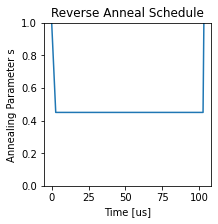

In [66]:
make_anneal_plot(reverse_schedule)

In [67]:
# Assign best Sampleset
best_sampleset = sampleset_35

In [68]:

i5 = int(5.0/95*len(best_sampleset))  # Index i5 is about a 5% indexial move from the sample of lowest energy

initial = dict(zip(best_sampleset.variables, best_sampleset.record[i5].sample))
reverse_anneal_params = dict(anneal_schedule=reverse_schedule, initial_state=initial, reinitialize_state=False)

# The `reinitialize_state` parameter switches between two qualitatively different methods of local search 
# via quantum annealing.  With `reinitialize_state = 'True'`, many anneals are seeded from the single starting 
# state and the states returned, modulo time-dependent sources of error, are independently and identically 
# distributed.  With `reinitialize_state = 'False'`, the series of anneals behaves like a random walk and 
# is capable of exploring the solution space more broadly.  


In [69]:
sampleset_reverse1 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr,
                                                                   **reverse_anneal_params)  


In [70]:
analyze(sampleset_reverse1, "reverse_schedule1", data)

Good solutions are 2.4% of samples.
Best Known solutions are 0.2% of samples.
Lowest energy found: [-9.754999999999999]
Average energy is 1.76 with standard deviation 6.48


In [71]:
sampleset_reverse2 = FixedEmbeddingComposite(qpu, embedding).sample(bqm, 
                                                                   answer_mode="raw", 
                                                                   num_reads=numr, 
                                                                   chain_strength= chnstr,
                                                                   **reverse_anneal_params)  


In [72]:
analyze(sampleset_reverse2, "reverse_schedule2", data)

Good solutions are 4.2% of samples.
Best Known solutions are 0.6% of samples.
Lowest energy found: [-9.86]
Average energy is 2.27 with standard deviation 7.38


#### Make table of solutions:

In [73]:
df = pd.DataFrame(data, columns=["Label", "Best Known Solutions (%)", "Good Known Solutions (%)", "Lowest Energy", "Average Energy", "Standard Deviation"])
data

[['embedding1A', 0.2, 1.0, -9.719999999999999, 3.21359, 8.122751224917577],
 ['embedding1B', 0.2, 0.4, -9.51, 4.2382800000000005, 8.017568511812044],
 ['embedding2A', 0.4, 1.2, -10.0, 2.9679300000000004, 7.917487313857851],
 ['embedding2B', 0.2, 1.8, -9.965, 3.5383500000000003, 8.244238062277192],
 ['embedding3A',
  0.2,
  3.2,
  -9.719999999999999,
  4.2304900000000005,
  7.984036316920158],
 ['embedding3B', 0.2, 1.4, -10.0, 2.4162600000000003, 7.381951016662194],
 ['default_chains',
  0.4,
  2.4,
  -9.719999999999999,
  3.3760300000000005,
  7.649284625969934],
 ['scaled_chains1',
  0.2,
  0.2,
  -3.2300000000000004,
  53.36121000000001,
  25.272740478347416],
 ['scaled_chains2',
  0.2,
  0.2,
  -4.614999999999999,
  59.25560000000001,
  26.970176108805816],
 ['torque_chains1', 0.2, 3.2, -10.0, 2.70609, 7.633679379034726],
 ['torque_chains2', 0.2, 2.0, -9.719999999999999, 4.25493, 8.161029809104976],
 ['time_20', 0.4, 1.8, -9.79, 3.704630000000001, 7.3150070822317055],
 ['time_25', 0

In [74]:
df

,Label,Best Known Solutions (%),Good Known Solutions (%),Lowest Energy,Average Energy,Standard Deviation
0,embedding1A,0.2,1.0,-9.720,3.21359,8.122751
1,embedding1B,0.2,0.4,-9.510,4.23828,8.017569
2,embedding2A,0.4,1.2,-10.000,2.96793,7.917487
3,embedding2B,0.2,1.8,-9.965,3.53835,8.244238
4,embedding3A,0.2,3.2,-9.720,4.23049,7.984036
5,embedding3B,0.2,1.4,-10.000,2.41626,7.381951
6,default_chains,0.4,2.4,-9.720,3.37603,7.649285
7,scaled_chains1,0.2,0.2,-3.230,53.36121,25.272740
8,scaled_chains2,0.2,0.2,-4.615,59.25560,26.970176
9,torque_chains1,0.2,3.2,-10.000,2.70609,7.633679
